Завдання щодо генерації або стилізації зображень (на вибір)  
Вирішіть завдання перенесення стилю або генерації зображень (архітектура за вашим вибором: GAN/DCGAN/VAE/Diffusion).  
Датасети: можна брати CIFAR-100, Fashion MNIST або тут: https://www.kaggle.com/tags/image-data  

Для виконання завдання було обрано генерацію нових зображень з викоританням архітектури VAE та датасету Fashion MNIST.

2024-12-28 13:29:33.880488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735385373.922483  317240 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735385373.935501  317240 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-28 13:29:33.979489: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-28 13:29:43.264592: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL

Epoch 1/20


2024-12-28 13:29:47.626281: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


469/469 ━━━━━━━━━━━━━━━━━━━━ 80s 156ms/step - loss: 354.6080 - val_loss: 257.9674
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 67s 143ms/step - loss: 253.1178 - val_loss: 249.5431
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 71s 151ms/step - loss: 247.0324 - val_loss: 246.7532
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 73s 155ms/step - loss: 244.0138 - val_loss: 245.1854
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 79s 169ms/step - loss: 242.8605 - val_loss: 243.9010
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 174ms/step - loss: 242.3410 - val_loss: 243.0431
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 84s 180ms/step - loss: 241.0322 - val_loss: 242.1124
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 175ms/step - loss: 240.8396 - val_loss: 242.0005
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 80s 170ms/step - loss: 240.6105 - val_loss: 241.4205
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 178ms/step - loss: 239.3316 - val_loss: 241.2649
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 175ms/step - loss: 239.1247 - val_l

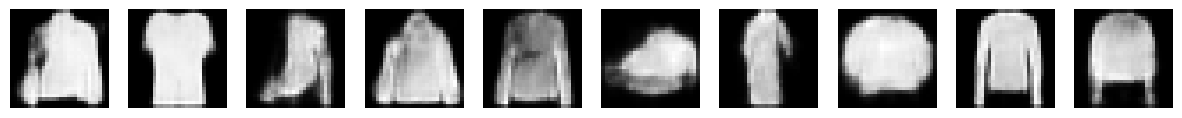

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

# Завантаження та підготовка датасету Fashion MNIST
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

latent_dim = 16
input_shape = (28, 28, 1)

# Енкодер
encoder_inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(encoder_inputs)
x = layers.Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

def sampling(args):
    mean, log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(mean)[0], latent_dim))
    return mean + tf.exp(0.5 * log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Декодер
decoder_inputs = layers.Input(shape=(latent_dim,))
y = layers.Dense(7 * 7 * 64, activation='relu')(decoder_inputs)
y = layers.Reshape((7, 7, 64))(y)
y = layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(y)
y = layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(y)
decoder_outputs = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(y)
decoder = Model(decoder_inputs, decoder_outputs, name='decoder')

# Клас VAE з методом call, де обчислюється сума втрат
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        # Обчислення реконструкційної втрати
        reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x, reconstruction), axis=(1,2))
        reconstruction_loss *= 28 * 28
        # KL-доданок
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        # Додаємо загальну втрату
        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        self.add_loss(total_loss)
        return reconstruction

# Створюємо модель VAE і тренуємо
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(x_train, x_train, epochs=20, batch_size=128, validation_data=(x_test, x_test))

# Функція для візуалізації згенерованих зображень
def plot_generated_images(decoder, n=10):
    random_latent_vectors = np.random.normal(size=(n, latent_dim))
    generated_images = decoder.predict(random_latent_vectors)
    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()

plot_generated_images(decoder)